# Phase Change Diagrams and Visualizations

## LaTeX Prerequisites

**Required for PGF export and LaTeX rendering:**

1. **Install TinyTeX** (lightweight LaTeX distribution):
   ```bash
   brew install --cask basictex
   echo 'export PATH="/Library/TeX/texbin:$PATH"' >> ~/.zshrc
   source ~/.zshrc
   ```

2. **Install required packages**:
   ```bash
   sudo tlmgr update --self --all
   sudo tlmgr install underscore type1cm type1ec latexmk pgf xcolor xkeyval etoolbox geometry amsmath amsfonts lm cm-super courier helvetic fontaxes siunitx ulem graphics
   ```

3. **Verify installation**:
   ```bash
   which pdflatex && pdflatex --version
   tlmgr --version
   ```

**Alternative**: Set `plt.rcParams['text.usetex'] = False` in the imports cell to disable LaTeX entirely.

---

This notebook regenerates the Phase Change Diagrams from .npz files and creates comprehensive visualizations including:
1. Box and whisker plots for model comparisons
2. Phase Change Diagrams with color maps
3. All visualizations rendered in matplotlib and exported to PGF format

## Data Sources
- .npz files containing phase change experiment results and configs


In [ ]:
import os

base_path = '/Users/Rome/GithubRepos/moe-superposition'
data_path = f'{base_path}/phase_change_data'

# Configure output directory for saved figures
output_dir = 'phase_change_final_figures'  # Change this to your preferred subfolder name
output_path = f'{base_path}/{output_dir}'

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

## Imports

In [4]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import pandas as pd
import torch
import os
import glob
import re
from pathlib import Path
from typing import Dict, List, Any, Tuple, Sequence, Literal
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style for publication-quality figures
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['patch.linewidth'] = 1.0

plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

print("Libraries imported successfully")


Libraries imported successfully


## Helpers

In [5]:
def norm_and_superposition(
    W: Sequence[Sequence[float]] | np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    W
        An (n_features, d) array-like of feature / weight vectors.
        If you pass a single 1-D vector, it will be treated as shape (1, d).

    Returns
    -------
    norms         : shape (n_features,)   L2 norms  ‖Wᵢ‖₂
    superposition : shape (n_features,)   ∑ⱼ (x̂ᵢ·x̂ⱼ)²  with j ≠ i
    """
    if torch.is_tensor(W):
        W = W.detach().cpu().numpy()
    W = np.asarray(W, dtype=float)
    if W.ndim == 1:                       # allow a single vector
        W = W[None, :]

    # --- 1. Norms -----------------------------------------------------------
    norms = np.linalg.norm(W, axis=1)     # ‖Wᵢ‖₂ for every row

    # --- 2. Normalise & build cosine-similarity matrix ----------------------
    # Handle zero vectors safely:
    W_hat = np.divide(W, norms[:, None], where=norms[:, None] != 0)

    cos = W_hat @ W.T                 # cos[i, j] = x̂ᵢ·x̂ⱼ

    # superᵢ = Σⱼ (cos[i, j])² but exclude j = i
    superposition = (cos**2).sum(axis=1) - 1.0   # subtract self-term (1²)

    return norms, superposition

In [6]:
# Import the correct functions from helpers
import sys
sys.path.append(base_path)

# Phase change visualization functions - CLEAN IMPLEMENTATION
def superposition_measure(x_i: np.ndarray, X: np.ndarray) -> float:
    """Σ_j ( x̂_i · x_j )²  – 'superposition score' for one feature."""
    if np.linalg.norm(x_i) == 0:
        return 0.0
    x_hat_i = x_i / np.linalg.norm(x_i)
    overlaps = X @ x_hat_i
    return float(np.sum(overlaps**2))

def compute_feature_metrics(W: np.ndarray) -> pd.DataFrame:
    """
    For every row of a weight-matrix **W** (shape = (n_features, d)) return:
      • norm         – ‖W_i‖
      • super_score  – Σ_j (x̂_i·x_j)²
      • x_coord      – clipped super_score  (what the paper puts on x-axis)
      • y_coord      – clipped norm         (what the paper puts on y-axis)
      • colour_hex   – HTML / matplotlib colour that matches the legend
    """
    if torch.is_tensor(W):
        W = W.detach().cpu().numpy()
    
    rows = []
    for i in range(W.shape[0]):
        norm_i = np.linalg.norm(W[i])
        sup_i  = superposition_measure(W[i], W)
        x_i    = sup_i
        y_i    = norm_i
        rows.append(
            (norm_i, sup_i, x_i, y_i, rgb_to_hex(color_from_xy(x_i, y_i)))
        )

    return pd.DataFrame(
        rows,
        columns=["norm", "super_score", "x_coord", "y_coord", "colour_hex"],
    )

# Color mapping functions for joint phase change diagrams
dim_scalar = 1

def color_from_metrics(norm: float, superpos: float, max_norm: float, max_super: float) -> Tuple[float, float, float]:
    """
    Map (norm, superpos) to an RGB tuple with:
    - Top right (high norm, high super) -> Red
    - Top left (high norm, low super) -> Blue
    - Bottom (low norm) -> White
    
    Args:
        norm: L2 norm of the weights
        superpos: Superposition score
        max_norm: Maximum norm for normalization
        max_super: Maximum superposition score for normalization
    """
    # Normalize inputs to [0,1]
    y = np.clip(norm / max_norm, 0.0, dim_scalar)      # Vertical axis (norm)
    x = np.clip(superpos / max_super, 0.0, dim_scalar)  # Horizontal axis (superposition)
    
    # Create color components
    red = y * x           # Increases towards top-right
    blue = y * (dim_scalar - x)    # Increases towards top-left
    # All components approach 1 (white) as y approaches 0 (bottom)
    white_blend = dim_scalar - y
    
    # Blend with white
    r = red + white_blend
    g = white_blend
    b = blue + white_blend
    
    # Normalize to [0,1]
    return (
        min(dim_scalar, max(0.0, r)),
        min(dim_scalar, max(0.0, g)),
        min(dim_scalar, max(0.0, b))
    )

def create_colormap_legend(n: int = 100) -> np.ndarray:
    """Create a small colormap legend for the phase change diagrams"""
    color_grid = np.zeros((n, n, 3), dtype=float)
    norms = np.linspace(0.0, dim_scalar, n)
    supers = np.linspace(0.0, dim_scalar, n)
    for i, y in enumerate(norms):
        for j, x in enumerate(supers):
            color_grid[i, j] = color_from_metrics(
                norm=y, superpos=x, max_norm=1.0, max_super=1.0
            )
    return color_grid

def color_from_xy(x: float, y: float, max_x: float = 1.0, max_y: float = 1.0) -> tuple[float, float, float]:
    """
    Reconstruct the paper's legend → RGB.
      • x (horizontal)  = superposition score, clipped to ≤ 1
          0 ⇒ blue,  1 ⇒ red
      • y (vertical)    = ‖W_i‖,           clipped to ≤ 1
          0 ⇒ white, 1 ⇒ full-strength hue
    """
    max_x = max(max_x, 1)
    max_y = max(max_y, 1)

    base = np.array([x, 0.0, max_x - x])      # blue→red ramp
    return tuple(y * base + (max_y - y))        # mix with white

def rgb_to_hex(rgb: tuple[float, float, float]) -> str:
    return '#{:02x}{:02x}{:02x}'.format(
        *(int(round(255 * c)) for c in rgb)
    )

print("Clean phase change visualization functions defined")


Clean phase change visualization functions defined


In [7]:
def extract_expert_data_from_npz(path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Extract expert data and grid parameters from npz file
    Returns: s_vals, m_vals, expert_weights, losses
    """
    data = np.load(path, allow_pickle=True)
    keys = list(data.keys())
    
    # Get sparsity and importance axes
    s_vals = None
    m_vals = None
    for k in keys:
        kk = k.lower()
        arr = data[k]
        if s_vals is None and ('spars' in kk or 's_values' in kk) and arr.ndim == 1:
            s_vals = np.asarray(arr)
        if m_vals is None and ('importance' in kk or 'm_values' in kk) and arr.ndim == 1:
            m_vals = np.asarray(arr)
    
    # Get expert weights - use the correct key name
    expert_weights = None
    if 'expert_weights_list' in keys:
        expert_weights = data['expert_weights_list']
        print(f"  Found expert_weights_list with shape: {expert_weights.shape}")
    elif 'expert_weights' in keys:
        expert_weights = data['expert_weights']
        print(f"  Found expert_weights with shape: {expert_weights.shape}")
    else:
        print(f"  No expert weights found in keys: {keys}")
    
    # Get loss data
    losses = None
    if 'final_losses' in keys:
        losses = data['final_losses']
        # Reshape if needed
        S, M = len(s_vals), len(m_vals)
        if losses.ndim == 1:  # [S*M]
            losses = losses.reshape(S, M)
        elif losses.ndim == 2:  # [S, M]
            pass  # Already correct shape
        else:
            raise ValueError(f'Unexpected loss data shape: {losses.shape}')
        print(f"  Losses shape: {losses.shape}")
    
    return s_vals, m_vals, expert_weights, losses

def load_all_npz_files() -> Dict[str, Dict[str, Any]]:
    """Load all .npz files from the project with corrected XYZ interpretation
    XYZ.npz = X input dims, Y hidden dims, contains Z experts
    Each expert gets its own entry in the returned dictionary
    """
    # Define search directories
    results_dirs = [
        data_path
    ]
    
    npz_files = []
    seen_files = set()
    
    # Only use files from the main directory to avoid duplicates
    if os.path.isdir(data_path):
        files = sorted(glob.glob(os.path.join(data_path, '*.npz')))
        for f in files:
            basename = os.path.basename(f)
            if re.match(r'^(\d{3})\.npz$', basename) and basename not in seen_files:
                npz_files.append(f)
                seen_files.add(basename)
    
    print(f"Found {len(npz_files)} .npz files in main directory:")
    for f in npz_files:
        print(f"  - {os.path.basename(f)}")
    
    # Process files - extract individual experts from each file
    all_data = {}
    
    for f in npz_files:
        base = os.path.basename(f)
        m = re.match(r'^(\d{3})\.npz$', base)
        if not m:
            continue
        code = m.group(1)
        input_dims = int(code[0])
        hidden_dims = int(code[1]) 
        num_experts = int(code[2])  # This is the number of experts, not a specific expert number
        
        try:
            s_vals, m_vals, expert_weights, losses = extract_expert_data_from_npz(f)
            
            print(f"Processing {base}: {input_dims}x{hidden_dims} network with {num_experts} experts")
            print(f"  Expert weights shape: {expert_weights.shape if expert_weights is not None else 'None'}")
            
            # Extract individual experts from the expert_weights
            if expert_weights is not None and expert_weights.ndim == 4:
                # Shape: [n_grid_points, n_experts, n_features, n_hidden]
                actual_num_experts = expert_weights.shape[1]  # Get actual number from data
                print(f"  Found {actual_num_experts} experts in expert_weights")
                
                for expert_idx in range(actual_num_experts):
                    # Create unique expert ID using base name and expert number
                    expert_id = f"{base}_{expert_idx + 1}"  # e.g., "211_1", "212_1", "212_2"
                    
                    # Extract this expert's weights
                    expert_weights_single = expert_weights[:, expert_idx, :, :]  # [n_grid_points, n_features, n_hidden]
                    
                    all_data[expert_id] = {
                        'input_dims': input_dims,
                        'hidden_dims': hidden_dims,
                        'expert_num': expert_idx + 1,  # Expert numbers start from 1
                        's_vals': s_vals,
                        'm_vals': m_vals,
                        'expert_weights': expert_weights_single,
                        'losses': losses,  # Same losses for all experts in this file
                        'base_name': base,
                        'file_path': f
                    }
                    
                    print(f"  Extracted Expert {expert_idx + 1}: weights shape {expert_weights_single.shape}")
                    
            elif expert_weights is not None and expert_weights.ndim == 3:
                # Shape: [n_grid_points, n_features, n_hidden] - single expert
                expert_id = f"{base}_1"  # Single expert
                
                all_data[expert_id] = {
                    'input_dims': input_dims,
                    'hidden_dims': hidden_dims,
                    'expert_num': 1,
                    's_vals': s_vals,
                    'm_vals': m_vals,
                    'expert_weights': expert_weights,
                    'losses': losses,
                    'base_name': base,
                    'file_path': f
                }
                
                print(f"  Single expert: weights shape {expert_weights.shape}")
                
            else:
                print(f"  No expert weights found in {base}")
                continue
                
        except Exception as e:
            print(f'Error processing {base}: {e}')
            continue
    
    return all_data

print("Data loading functions defined")


Data loading functions defined


In [17]:
# Box and whisker plot function (FIXED: shows individual models, not grouped by architecture)
def plot_all_models_box_whisker_matplotlib(all_data: Dict[str, Dict[str, Any]], 
                                          labels: List[str] = None) -> plt.Figure:
    """
    Create a matplotlib box and whisker plot for all individual models (8 models total).
    
    Args:
        all_data: Dictionary with model data
        labels: Optional list of labels for each model
    """
    if labels is None:
        labels = list(all_data.keys())
    

    # Extract all losses for each individual model (8 models total)
    all_model_losses = []
    model_labels = []
    
    for setup, data in all_data.items():
        if setup in labels:
            losses = data['losses']
            # Flatten all losses for this model (across all experts and grid points)
            model_losses = losses.flatten()
            all_model_losses.append(model_losses)
            model_labels.append(setup.replace('32', 'C/').replace('21', 'A/').replace('31', 'B/'))
    
    # Remove labels ending with _2 or _3 (duplicate models)
    filtered = [(labels, i) for i, label in enumerate(model_labels) if not (label.endswith('_2') or label.endswith('_3'))]
    model_labels = [model_labels[i][:-6] for _, i in filtered]
    all_model_losses = [all_model_losses[i] for _, i in filtered]

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Colors for different models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Create box plot
    bp = ax.boxplot(all_model_losses, labels=model_labels, patch_artist=True, 
                    showfliers=True, whis=1.5)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors[:len(all_model_losses)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Style the plot
    # ax.set_title('Loss Distribution Across Models', fontsize=14, fontweight='bold')
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Final Loss', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

print("Box and whisker plot function defined")


Box and whisker plot function defined


## Load Data

In [15]:
# Load the data with corrected XYZ interpretation
print("Loading .npz files with corrected XYZ interpretation...")
all_data = load_all_npz_files()

if not all_data:
    print("No data found! Please check the file paths.")
else:
    print(f"\nSuccessfully loaded data for {len(all_data)} experts:")
    
    # Group by base name to check for duplicates
    by_base_name = {}
    for expert_id, data in all_data.items():
        base_name = data['base_name']
        if base_name not in by_base_name:
            by_base_name[base_name] = []
        by_base_name[base_name].append((expert_id, data))
    
    # Show summary by file
    for base_name, experts in by_base_name.items():
        print(f"  {base_name}: {len(experts)} experts")
        for expert_id, data in experts:
            print(f"    Expert {expert_id}: {data['input_dims']}x{data['hidden_dims']} network, expert {data['expert_num']}")
            if data['losses'] is not None:
                print(f"      Loss range: [{data['losses'].min():.4f}, {data['losses'].max():.4f}]")
            if data['expert_weights'] is not None:
                print(f"      Expert weights shape: {data['expert_weights'].shape}")
    
    # Check for duplicates and remove them
    print(f"\nChecking for duplicates...")
    unique_experts = {}
    for expert_id, data in all_data.items():
        # Create a unique key based on base_name and expert_num
        unique_key = f"{data['base_name']}_expert_{data['expert_num']}"
        if unique_key not in unique_experts:
            unique_experts[unique_key] = (expert_id, data)
        else:
            print(f"  Removing duplicate: {expert_id} (same as {unique_experts[unique_key][0]})")
    
    # Update all_data with unique experts only
    all_data = {expert_id: data for expert_id, data in unique_experts.values()}
    print(f"After deduplication: {len(all_data)} unique experts")


Loading .npz files with corrected XYZ interpretation...
Found 8 .npz files in main directory:
  - 211.npz
  - 212.npz
  - 311.npz
  - 312.npz
  - 313.npz
  - 321.npz
  - 322.npz
  - 323.npz
  Found expert_weights_list with shape: (2262, 1, 2, 1)
  Losses shape: (39, 58)
Processing 211.npz: 2x1 network with 1 experts
  Expert weights shape: (2262, 1, 2, 1)
  Found 1 experts in expert_weights
  Extracted Expert 1: weights shape (2262, 2, 1)
  Found expert_weights_list with shape: (2262, 2, 2, 1)
  Losses shape: (39, 58)
Processing 212.npz: 2x1 network with 2 experts
  Expert weights shape: (2262, 2, 2, 1)
  Found 2 experts in expert_weights
  Extracted Expert 1: weights shape (2262, 2, 1)
  Extracted Expert 2: weights shape (2262, 2, 1)
  Found expert_weights_list with shape: (2262, 1, 3, 1)
  Losses shape: (39, 58)
Processing 311.npz: 3x1 network with 1 experts
  Expert weights shape: (2262, 1, 3, 1)
  Found 1 experts in expert_weights
  Extracted Expert 1: weights shape (2262, 3, 1)
  

## Create Box and Whisker Plot

Creating Box and Whisker Plot...
Box and whisker plot saved as '/Users/Rome/GithubRepos/moe-superposition/phase_change_final_figures/box_whisker_plot.png'
Box and whisker plot saved as '/Users/Rome/GithubRepos/moe-superposition/phase_change_final_figures/box_whisker_plot.pgf'
Box and whisker plot saved as '/Users/Rome/GithubRepos/moe-superposition/phase_change_final_figures/box_whisker_plot.pdf'


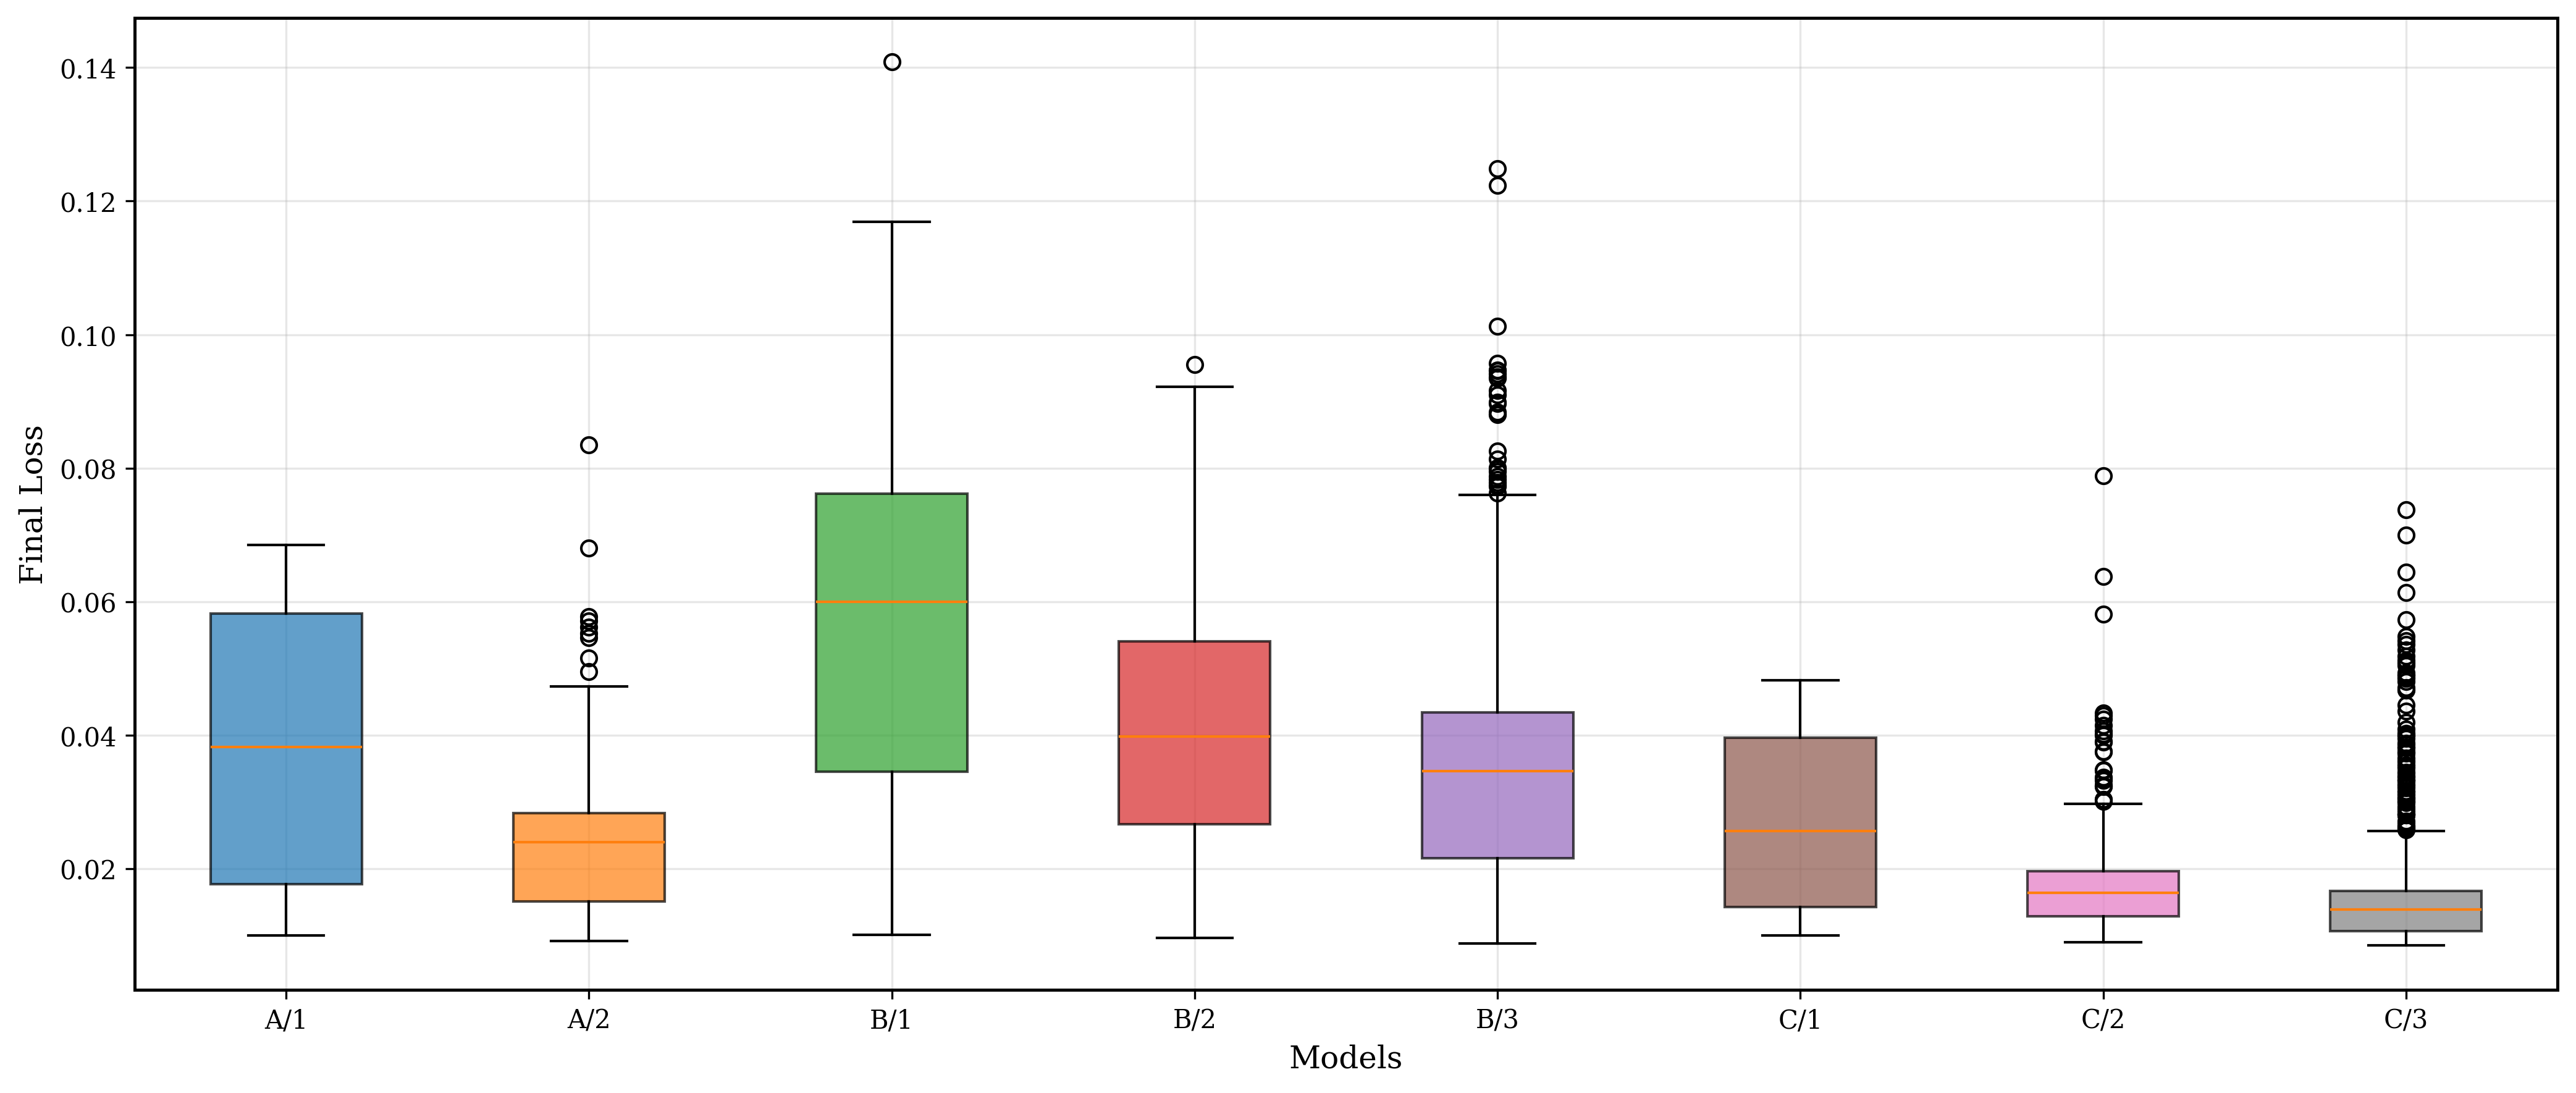

In [18]:
# Create Box and Whisker Plot
if all_data:
    print("Creating Box and Whisker Plot...")
    
    # Create the box and whisker plot
    fig_box = plot_all_models_box_whisker_matplotlib(all_data)
    
    # Save as PNG
    fig_box.savefig(f'{output_path}/box_whisker_plot.png', dpi=300, bbox_inches='tight')
    print(f"Box and whisker plot saved as '{output_path}/box_whisker_plot.png'")
    
    # Save as PGF for LaTeX (instead of PGF to avoid LaTeX errors)
    fig_box.savefig(f'{output_path}/box_whisker_plot.pgf')
    print(f"Box and whisker plot saved as '{output_path}/box_whisker_plot.pgf'")
    
    # Save as PDF
    fig_box.savefig(f'{output_path}/box_whisker_plot.pdf', bbox_inches='tight')
    print(f"Box and whisker plot saved as '{output_path}/box_whisker_plot.pdf'")
    
    plt.show()
else:
    print("No data available for box and whisker plot")


## Create Phase Diagrams Altogether

In [11]:
# Create Composite Figure with Architecture Diagrams and Color Legend
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from PIL import Image
import io
import xml.etree.ElementTree as ET

def create_architecture_diagram(arch_type, ax, title):
    """Create a simple architecture diagram for the given type"""
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if arch_type == '21':  # 2-1-2 architecture
        # Input layer (2 nodes)
        ax.scatter([2, 2], [3, 7], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        # Hidden layer (1 node)
        ax.scatter([5], [5], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        # Output layer (2 nodes)
        ax.scatter([8, 8], [3, 7], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        
        # Connections
        ax.plot([2, 5], [3, 5], 'k-', linewidth=1.5, alpha=0.7)
        ax.plot([2, 5], [7, 5], 'k-', linewidth=1.5, alpha=0.7)
        ax.plot([5, 8], [5, 3], 'k-', linewidth=1.5, alpha=0.7)
        ax.plot([5, 8], [5, 7], 'k-', linewidth=1.5, alpha=0.7)
        
    elif arch_type == '31':  # 3-1-3 architecture
        # Input layer (3 nodes)
        ax.scatter([2, 2, 2], [2, 5, 8], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        # Hidden layer (1 node)
        ax.scatter([5], [5], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        # Output layer (3 nodes)
        ax.scatter([8, 8, 8], [2, 5, 8], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        
        # Connections
        for y in [2, 5, 8]:
            ax.plot([2, 5], [y, 5], 'k-', linewidth=1.5, alpha=0.7)
            ax.plot([5, 8], [5, y], 'k-', linewidth=1.5, alpha=0.7)
            
    elif arch_type == '32':  # 3-2-3 architecture
        # Input layer (3 nodes)
        ax.scatter([2, 2, 2], [2, 5, 8], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        # Hidden layer (2 nodes)
        ax.scatter([5, 5], [3.5, 6.5], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        # Output layer (3 nodes)
        ax.scatter([8, 8, 8], [2, 5, 8], s=200, c='white', edgecolors='black', linewidth=2, zorder=3)
        
        # Connections
        for y_in in [2, 5, 8]:
            for y_hid in [3.5, 6.5]:
                ax.plot([2, 5], [y_in, y_hid], 'k-', linewidth=1.5, alpha=0.7)
                ax.plot([5, 8], [y_hid, y_in], 'k-', linewidth=1.5, alpha=0.7)

def create_color_legend(ax):
    """Create a clean color legend showing the mapping"""
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    
    # Create color grid
    n = 100
    color_grid = np.zeros((n, n, 3), dtype=float)
    norms = np.linspace(0.0, 1.0, n)
    supers = np.linspace(0.0, 1.0, n)
    
    for i, y in enumerate(norms):
        for j, x in enumerate(supers):
            color_grid[i, j] = color_from_metrics(
                norm=y, superpos=x, max_norm=1.0, max_super=1.0
            )
    
    # Display the color grid
    ax.imshow(color_grid, extent=[0, 10, 0, 10], aspect='equal', origin='lower')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Superposition Score')
    ax.set_ylabel('L2 Norm')

def create_composite_figure_header(fig=None, axs=None):
    """Create the composite figure with architecture diagrams above heatmaps"""
    
    # Create figure with subplots
    if not fig:
        fig, axs = plt.subplots(1, 5, figsize=(20, 12))
        
    axs[3].set_visible(False)
    
    # Create a grid layout: 2 rows (architectures + heatmaps), 4 columns (3 architectures + legend)
    gs = fig.add_gridspec(4, 5, height_ratios=[0.7,1,1,1], width_ratios=[0.001, 0.99, 2, 2, 0.001], 
                         hspace=0, wspace=0)
    gs2 = fig.add_gridspec(4, 5, height_ratios=[0.42,1,1,1], width_ratios=[1, 1, 1, 1.25, 0.75], 
                         hspace=0, wspace=0)
    
    # Architecture diagrams (top row) - no titles
    for i, arch in enumerate(['21', '31', '32']):
        # ax = fig.add_subplot(gs[0, i])
        ax = axs[i]
        ax.set_subplotspec(gs[i+1])
        create_architecture_diagram(arch, ax, None)
    
    # Color legend (top right)
    create_color_legend(axs[4])
    axs[4].set_subplotspec(gs2[4])

    # Add overall title
    # fig.suptitle('Phase Change Analysis Across Architectures', fontsize=20, fontweight='bold', y=0.95)
    
    fig.tight_layout()
    return fig

Creating composite figure that composes all analyze_norm_and_superposition_all_experts figures...
Creating composite figure with 15 experts from 8 models
Processing A.1/1
Processing A.1/2
Processing A.2/2
Processing B.1/1
Processing B.1/2
Processing B.2/2
Processing B.1/3
Processing B.2/3
Processing B.3/3
Processing C.1/1
Processing C.1/2
Processing C.2/2
Processing C.1/3
Processing C.2/3
Processing C.3/3
Composite figure saved as '/Users/Rome/GithubRepos/moe-superposition/phase_change_final_figures/composite_analyze_norm_superposition_all_experts.png'
Composite figure saved as '/Users/Rome/GithubRepos/moe-superposition/phase_change_final_figures/composite_analyze_norm_superposition_all_experts.pgf'
Composite figure saved as '/Users/Rome/GithubRepos/moe-superposition/phase_change_final_figures/composite_analyze_norm_superposition_all_experts.pdf'


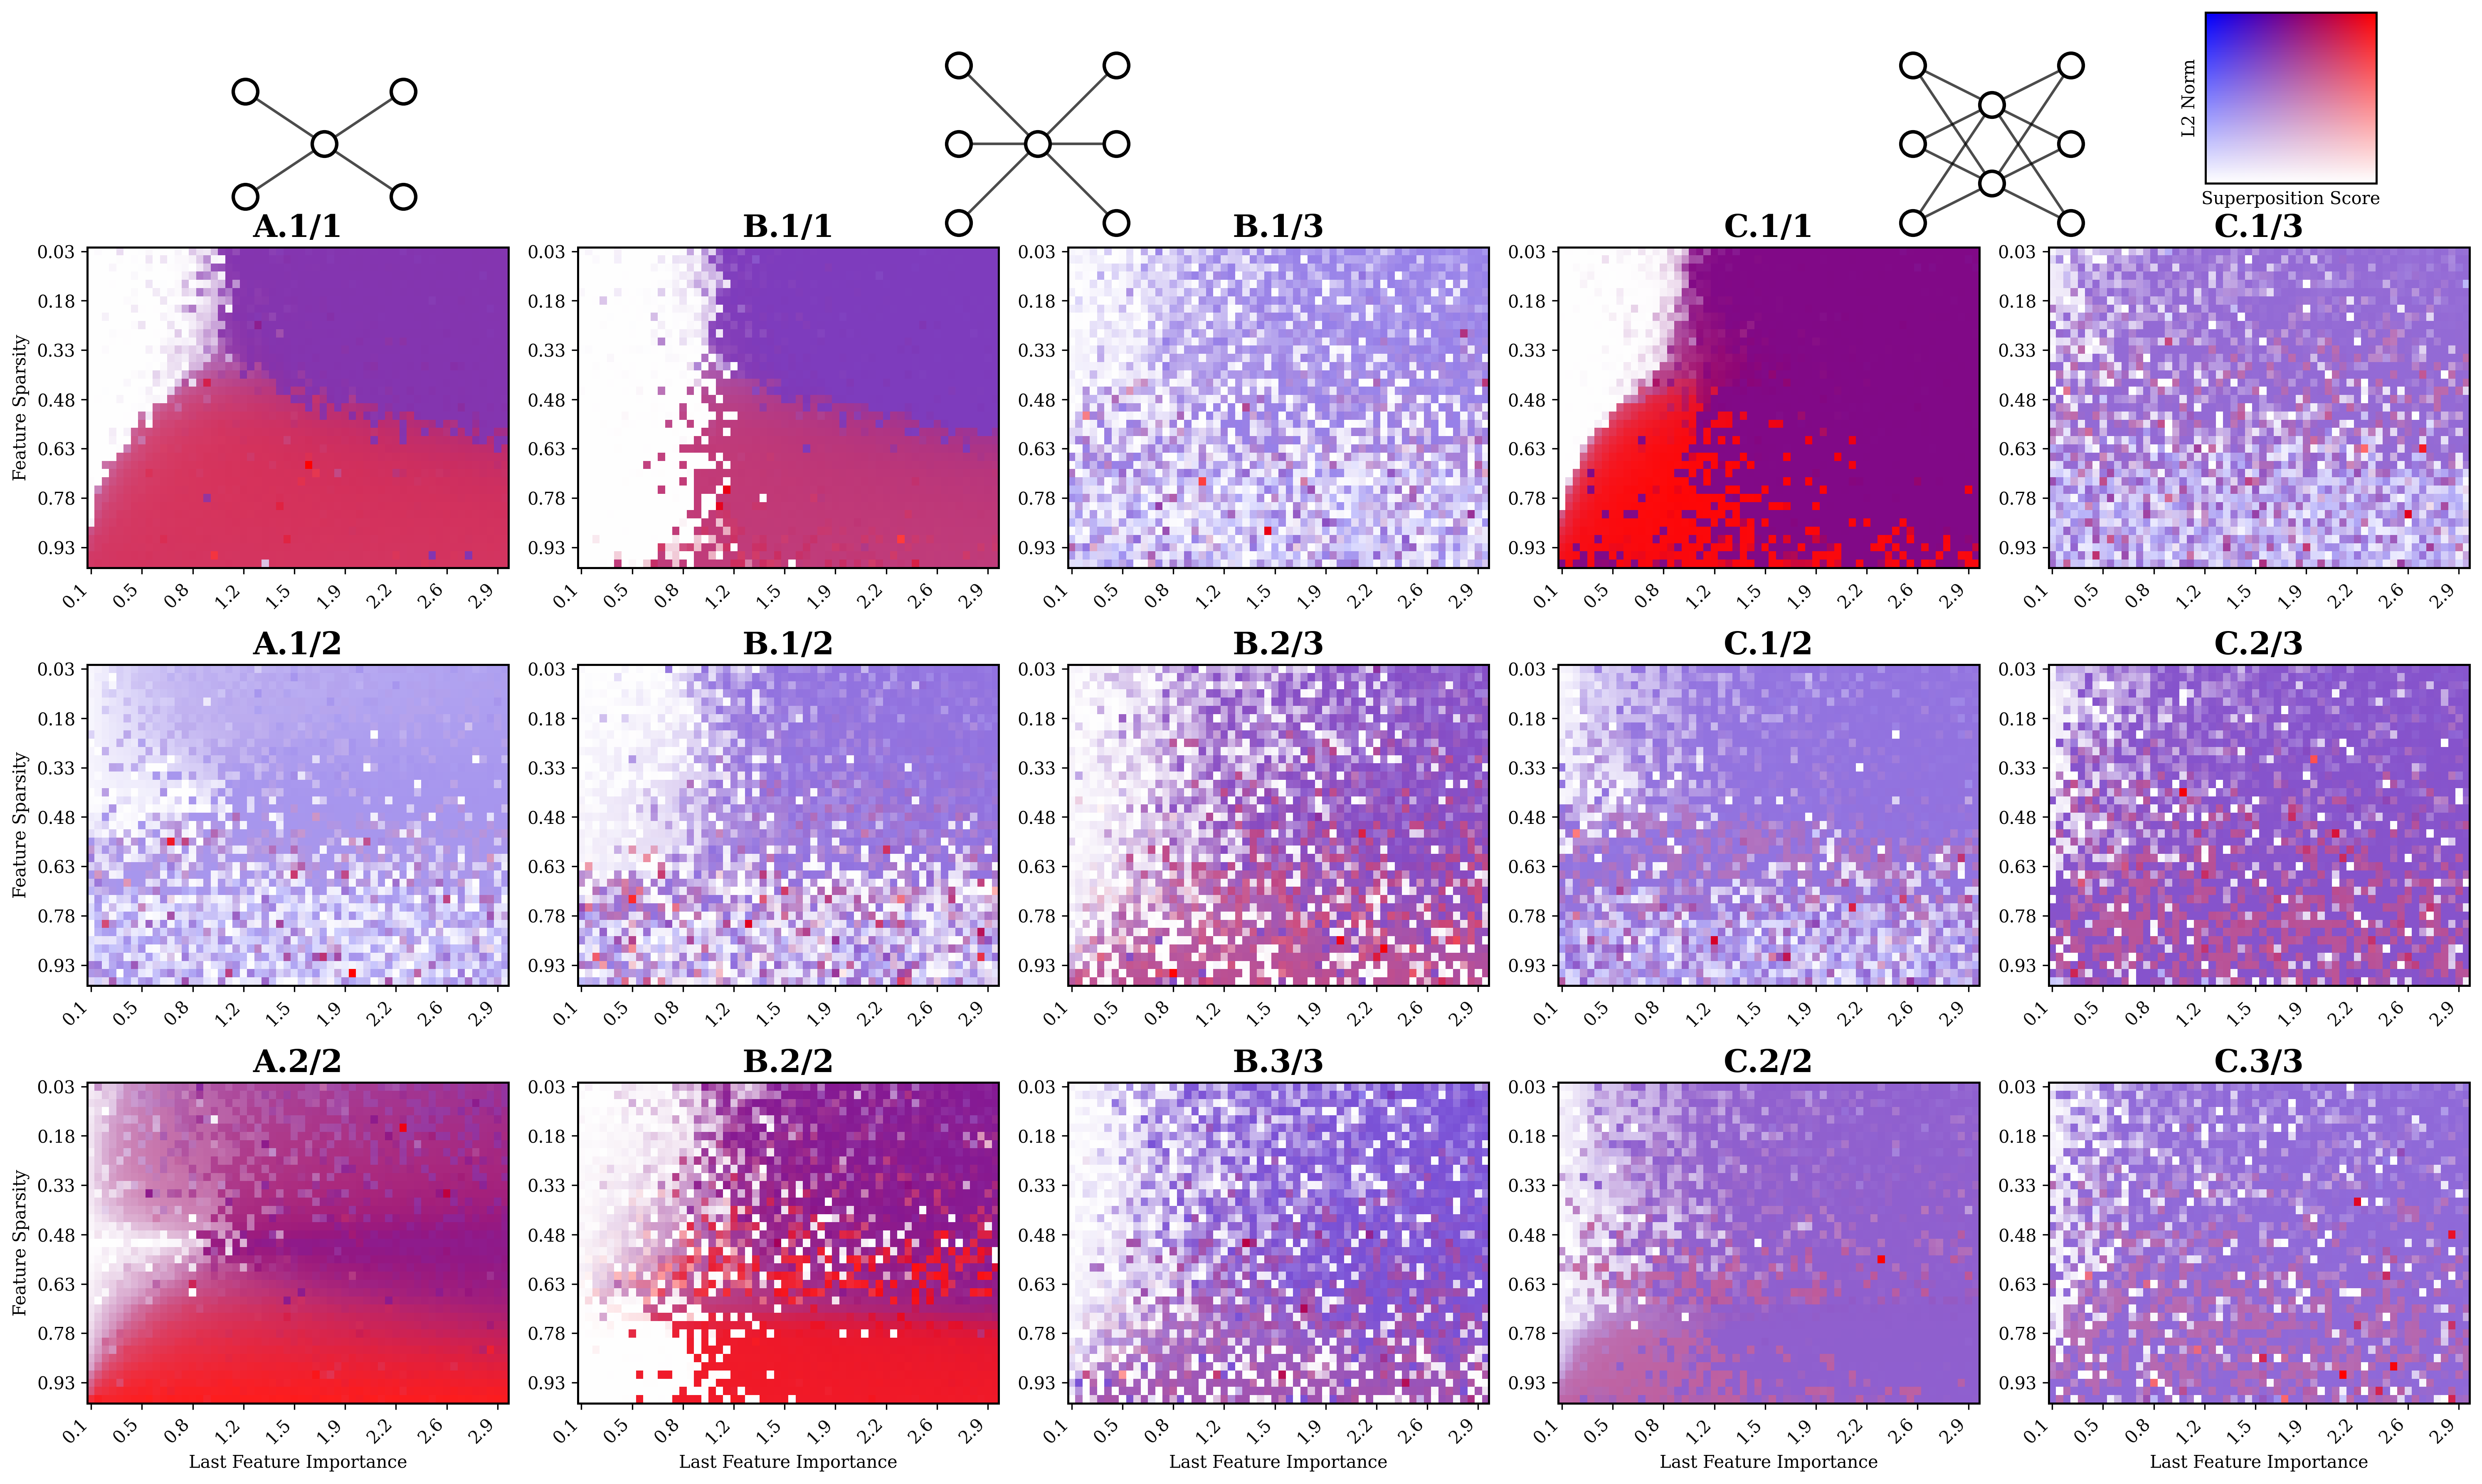

In [13]:
import matplotlib.gridspec as gridspec
from dataclasses import dataclass

@dataclass
class AnalysisConfig:
    """Configuration for analysis parameters"""
    sparsity_values: np.ndarray
    importance_values: np.ndarray
    n_experts: int
    n_features: int
    n_hidden: int

def create_composite_from_analyze_norm_superposition_figures(all_data: Dict[str, Dict[str, Any]]) -> plt.Figure:
    """
    Create a composite figure by composing the actual figures generated by analyze_norm_and_superposition_all_experts
    into one big file, excluding duplicates.
    Only shows the 3rd subplot (combined color visualization) for each expert.
    Arranges them in a 3x5 grid tiling top-to-bottom, then left-to-right.
    Column 1 is A, Columns 2-3 are B, Columns 4-5 are C.
    """
    # Group experts by their base configuration (input_dims, hidden_dims)
    model_groups = {}
    for expert_id, data in all_data.items():
        # Extract base key from base_name (e.g., "211_1" -> "211")
        base_key = data['base_name'].split('.')[0]  # Remove .npz extension
        if base_key not in model_groups:
            model_groups[base_key] = []
        model_groups[base_key].append((expert_id, data))
    
    # Sort experts within each group by expert number
    for base_key in model_groups:
        model_groups[base_key].sort(key=lambda x: x[1]['expert_num'])
    
    # Count total experts and organize by model
    total_experts = 0
    model_info = []
    
    for model_key, expert_list in model_groups.items():
        # Get the first expert's data to extract grid parameters
        first_expert_data = expert_list[0][1]
        s_vals = first_expert_data['s_vals']
        m_vals = first_expert_data['m_vals']
        n_experts = len(expert_list)
        total_experts += n_experts
        
        # Create configuration
        config = AnalysisConfig(
            sparsity_values=s_vals,
            importance_values=m_vals,
            n_experts=n_experts,
            n_features=first_expert_data['input_dims'],
            n_hidden=first_expert_data['hidden_dims']
        )
        
        model_info.append({
            'key': model_key,
            'config': config,
            'expert_list': expert_list,
            'n_experts': n_experts,
            'n_features': config.n_features,
            'n_hidden': config.n_hidden
        })
    
    print(f"Creating composite figure with {total_experts} experts from {len(model_info)} models")
    
    # Create a 3x5 grid for the combined color visualizations
    n_rows = 4
    n_cols = 5
    fig, axs_r = plt.subplots(n_rows, n_cols, figsize=(20, 12))
    gs = fig.add_gridspec(4, 5, height_ratios=[0.43,1,1,1])

    create_composite_figure_header(fig, axs_r.flatten())
    
    axs_r.flatten()
    axs = np.array(axs_r).reshape(n_rows, n_cols).transpose().flatten() # flip rows and columns
    
    # transpose the grid spec to match the axs array
    spec2d = np.empty((n_rows, n_cols), dtype=object)
    for r in range(n_rows):
        for c in range(n_cols):
            spec2d[r, c] = gs[r, c]

    # transpose if you want column-major orientation
    gs = spec2d.T.flatten()   # or np.transpose(spec2d, (1, 0))


    # Map model keys to architecture letters (A, B, C) based on column grouping
    architecture_map = {}
    architecture_letter = 'A'
    for i, model_key in enumerate(sorted(model_groups.keys())):
        architecture_map[model_key] = architecture_letter
        if i == 1 or i == 4:
            architecture_letter = chr(ord(architecture_letter) + 1)
    
    # Create a list of all experts with their architecture and position info
    all_experts = []
    for model_idx, info in enumerate(model_info):
        config = info['config']
        expert_list = info['expert_list']
        arch_letter = architecture_map[info['key']]
        
        for expert_id in range(config.n_experts):
            all_experts.append({
                'model_info': info,
                'config': config,
                'expert_id': expert_id,
                'arch_letter': arch_letter,
                'expert_num': expert_id + 1,
                'total_experts': config.n_experts
            })
    
    # Create grid_results for each model
    grid_results_by_model = {}
    for model_idx, info in enumerate(model_info):
        config = info['config']
        expert_list = info['expert_list']
        
        # Create grid_results dictionary in the format expected by analyze_norm_and_superposition_all_experts
        grid_results = {}
        
        # Extract expert weights for each grid point
        for i, sparsity in enumerate(config.sparsity_values):
            for j, importance in enumerate(config.importance_values):
                grid_idx = i * len(config.importance_values) + j
                
                # Collect expert weights for this grid point
                expert_weights_list = []
                for expert_id, expert_data in expert_list:
                    weights = expert_data['expert_weights'][grid_idx]  # [n_features, n_hidden]
                    expert_weights_list.append(weights)
                
                # Stack into [n_experts, n_features, n_hidden] format
                expert_weights = np.stack(expert_weights_list, axis=0)
                
                # Create result entry
                grid_results[(sparsity, importance)] = {
                    'expert_weights': expert_weights,
                    'final_loss': expert_list[0][1]['losses'][i, j] if expert_list[0][1]['losses'] is not None else 0.0
                }
        
        grid_results_by_model[info['key']] = grid_results

    current_subplot = 0
    expert_index = 0
    
    for i in range(n_rows * n_cols):
        if current_subplot % 4 == 0:
            current_subplot += 1
            continue
        if current_subplot > n_rows * n_cols:
            break

        expert_info = all_experts[expert_index]
        expert_index += 1
            
        model_info = expert_info['model_info']
        config = expert_info['config']
        expert_id = expert_info['expert_id']
        arch_letter = expert_info['arch_letter']
        expert_num = expert_info['expert_num']
        total_experts = expert_info['total_experts']
        
        print(f"Processing {arch_letter}.{expert_num}/{total_experts}")
        
        # Get grid results for this model
        grid_results = grid_results_by_model[model_info['key']]
        
        # Store metrics for each grid cell for this expert
        norm_grids = np.zeros((len(config.sparsity_values), len(config.importance_values)))
        superposition_grids = np.zeros((len(config.sparsity_values), len(config.importance_values)))
        color_grids = np.zeros((len(config.sparsity_values), len(config.importance_values), 3))

        # Analyze each grid cell for this expert
        for i, sparsity in enumerate(config.sparsity_values):
            for j, importance in enumerate(config.importance_values):
                result = grid_results[(sparsity, importance)]
                
                # Get expert weights (shape: [n_experts, n_features, n_hidden])
                expert_weights = result['expert_weights']
                
                # Get weights for this expert
                expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
                
                expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[-1]  # feature_index=-1
                
                norm_grids[i, j] = expert_metrics['norm']
                superposition_grids[i, j] = expert_metrics['super_score']

        # Analyze each grid cell for colors for this expert
        for i, sparsity in enumerate(config.sparsity_values):
            for j, importance in enumerate(config.importance_values):
                # Store RGB values for color visualization
                rgb_color = color_from_metrics(
                    norm_grids[i, j], 
                    superposition_grids[i, j],
                    max_norm=np.max(norm_grids),
                    max_super=np.max(superposition_grids)
                )
                color_grids[i, j] = rgb_color

        # Use the subplot (combined color visualization) for this expert
        ax = axs[current_subplot]
        im = ax.imshow(color_grids, aspect='auto')
        if current_subplot < 4:
            ax.set_ylabel('Feature Sparsity')
        if current_subplot % 4 == 3:
            ax.set_xlabel('Last Feature Importance')
        
        # Create title in format: A.1/1, A.1/2, A.2/2, etc.
        title = f'{arch_letter}.{expert_num}/{total_experts}'
        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.set_subplotspec(gs[current_subplot])
        
        # Set tick labels
        x_step = max(1, len(config.importance_values) // 8)
        y_step = max(1, len(config.sparsity_values) // 6)
        
        x_ticks = range(0, len(config.importance_values), x_step)
        y_ticks = range(0, len(config.sparsity_values), y_step)
        
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'{config.importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{config.sparsity_values[i]:.2f}' for i in y_ticks])
        
        current_subplot += 1
    
    plt.tight_layout()
    return fig

# Generate the composite figure that composes all analyze_norm_and_superposition_all_experts figures
if all_data:
    print("Creating composite figure that composes all analyze_norm_and_superposition_all_experts figures...")

    # Create the composite figure
    composite_fig = create_composite_from_analyze_norm_superposition_figures(all_data)
    
    # Save the composite figure
    composite_fig.savefig(f'{output_path}/composite_analyze_norm_superposition_all_experts.png', dpi=300, bbox_inches='tight')
    print(f"Composite figure saved as '{output_path}/composite_analyze_norm_superposition_all_experts.png'")
    
    composite_fig.savefig(f'{output_path}/composite_analyze_norm_superposition_all_experts.pgf', bbox_inches='tight')
    print(f"Composite figure saved as '{output_path}/composite_analyze_norm_superposition_all_experts.pgf'")
    
    # Save as PDF
    composite_fig.savefig(f'{output_path}/composite_analyze_norm_superposition_all_experts.pdf', bbox_inches='tight')
    print(f"Composite figure saved as '{output_path}/composite_analyze_norm_superposition_all_experts.pdf'")
    
    plt.show()
